In [1]:
import sys
sys.path.append("../")
import os
from pathlib import Path
import shutil
import rasterio
import fnmatch
from glob import glob
import numpy as np
from ds_exploration.plotting_utils import plot_image

dir_ = "data/"

try:
    os.mkdir(dir_)
except:
    pass

In [2]:
os.chdir('../sentinelsat/')
import sentinelsat
from sentinelsat import SentinelAPI
from sentinelsat import SentinelProductsAPI
os.chdir('../notebooks/')

NameError: name 'os' is not defined

In [3]:
# register at https://scihub.copernicus.eu/dhus/#/home
user = 'hobbes778'
password = '123456TT'

In [4]:
def make_filter(pattern):
    def node_filter(node_info, include_pattern=pattern):
        return True if fnmatch.fnmatch(node_info["node_path"].lower(), include_pattern) else False
    return node_filter

In [9]:
def unarchive_download(file_path):
    unarchive_dir = file_path.parent
    shutil.unpack_archive(file_path, unarchive_dir)
    os.remove(file_path)

In [6]:
def extract_and_combine(zip_file_path):
    data_path = str(zip_file_path).replace(".zip", ".SAFE")
    band_files = glob(data_path + "/GRANULE/*/IMG_DATA/*.jp2")

    def get_band_array(band, band_files):
        band_file = [bf for bf in band_files if band in bf][0]
        array = rasterio.open(band_file).read(1)
        return array

    red = get_band_array("B04", band_files)
    green = get_band_array("B03", band_files)
    blue = get_band_array("B02", band_files)
    return np.dstack([red, green, blue])

In [1]:
def download_tiles(list_of_tiles, nfilter='*B??.jp2'):
    if nfilter:
        nodefilter=make_filter(nfilter)
        api = SentinelProductsAPI(user, password, 'https://scihub.copernicus.eu/dhus')
    else:
        api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
    
    for tile in list_of_tiles:
        print(f'Download tile name: {tile["tile_name"]} for {tile["date"][0]}, {tile["date"][1]}, with filter {nfilter}')
        name = tile['tile_name']
        date = tile['date']
        products = api.query(
            date=date, tileid=name,
            platformname='Sentinel-2', producttype='S2MSI1C'
        )
        if nfilter:
            downloaded_products = api.download_all(products, directory_path=dir_, n_concurrent_dl=5, nodefilter=nodefilter)
        else:
            downloaded_products = api.download_all(products, directory_path=dir_, n_concurrent_dl=5)
        
        print(downloaded_products)
        filename = [downloaded_products[0][k]['title'] for k in downloaded_products[0].keys()][0]
        zip_file_path = Path(f"{dir_}/{filename}.zip")
        unarchive_download(zip_file_path)
        
        rgb = extract_and_combine(zip_file_path)
        print(rgb.shape)
        plot_image(rgb, factor=5/2e4, clip_range=(0,1))

Download tile name: 10SEH for 20200928, 20200930, with filter None
(10980, 10980, 3)
Download tile name: 10TDK for 20201004, 20201009, with filter None


Downloading:   0%|          | 0.00/11.3M [00:00<?, ?B/s]
Downloading:  28%|██▊       | 3.15M/11.3M [00:00<00:02, 3.39MB/s]
Downloading:  74%|███████▍  | 8.39M/11.3M [00:01<00:00, 4.71MB/s][A
Downloading: 100%|██████████| 11.3M/11.3M [00:02<00:00, 4.39MB/s][A
MD5 checksumming: 100%|██████████| 11.3M/11.3M [00:00<00:00, 417MB/s]

Downloading:   0%|          | 3.15M/790M [00:02<09:29, 1.38MB/s]
Downloading:   1%|          | 4.19M/790M [00:02<06:37, 1.97MB/s]
Downloading:   1%|          | 5.24M/790M [00:02<05:00, 2.61MB/s]
Downloading:   1%|          | 6.29M/790M [00:02<04:02, 3.23MB/s]
Downloading:   1%|          | 7.34M/790M [00:03<03:25, 3.81MB/s]
Downloading:   1%|          | 8.39M/790M [00:03<03:00, 4.33MB/s]
Downloading:   1%|          | 9.44M/790M [00:03<02:44, 4.75MB/s]
Downloading:   1%|▏         | 10.5M/790M [00:03<02:33, 5.07MB/s]
Downloading:   1%|▏         | 11.5M/790M [00:03<02:25, 5.36MB/s]
Downloading:   2%|▏         | 12.6M/790M [00:03<02:19, 5.56MB/s]
Downloading:   2%|▏ 

(10980, 10980, 3)
Download tile name: 10TDL for 20200928, 20200930, with filter None


Downloading: 100%|██████████| 750M/750M [02:50<00:00, 4.41MB/s] 
MD5 checksumming: 100%|██████████| 750M/750M [00:01<00:00, 527MB/s] 


(10980, 10980, 3)


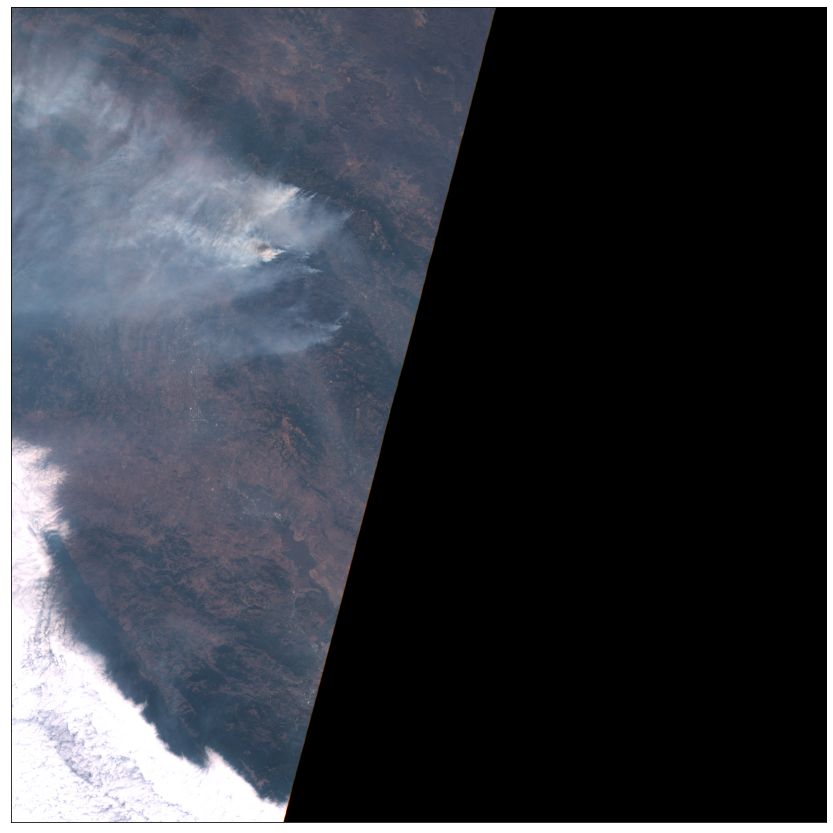

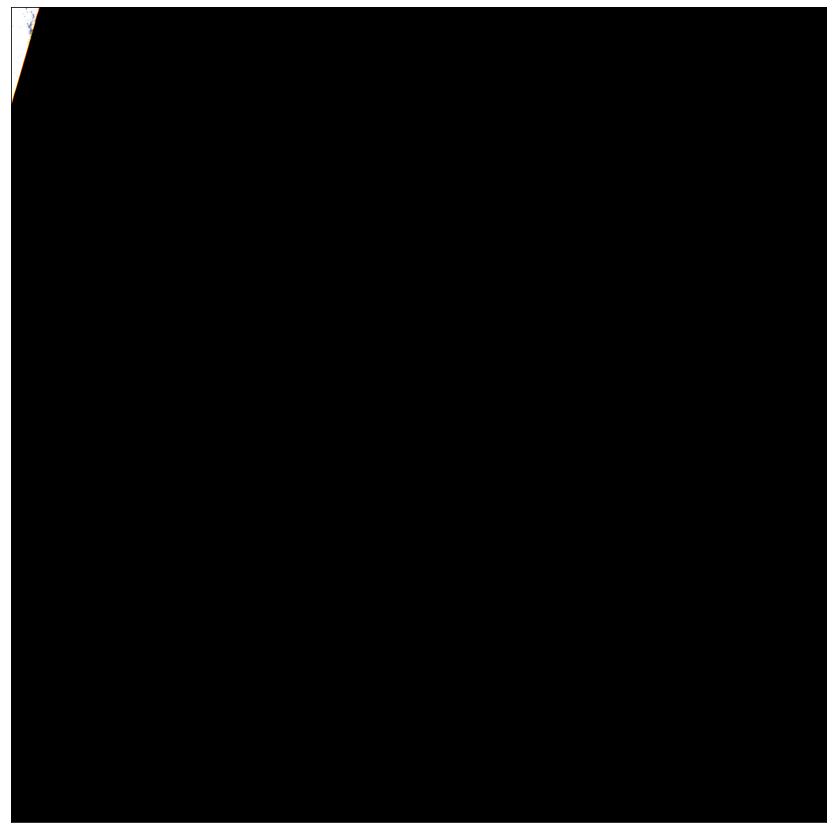

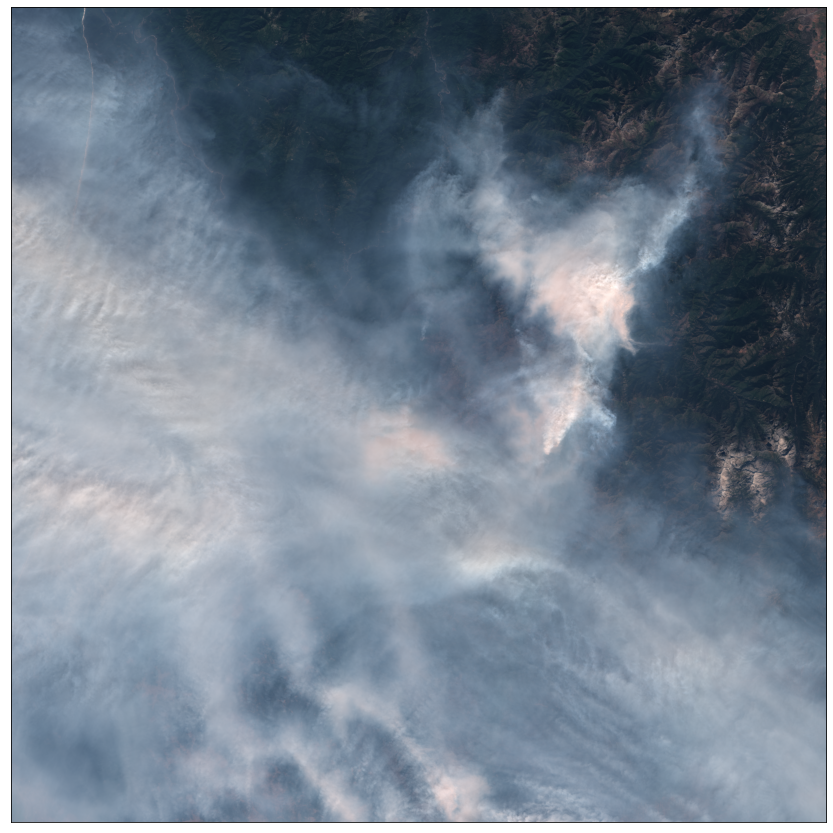

In [11]:
list_of_tiles = [
    {'tile_name': "10SEH", 'date': ('20200928', '20200930')},
    {'tile_name': "10TDK", 'date': ('20201004', '20201009')},
    {'tile_name': "10TDL", 'date': ('20200928', '20200930')},
]
download_tiles(list_of_tiles, nfilter=None)

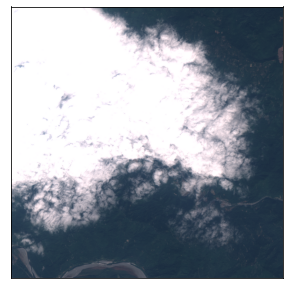

In [46]:
from skimage.util import view_as_blocks

blocks = view_as_blocks(rgb, block_shape=(1098, 1098, 3))
plot_image(blocks[1,1][0, :, :, :], factor=5/2e4, clip_range=(0,1), figsize=(5, 5))

(220, 220, 3) (1098, 1098, 3)


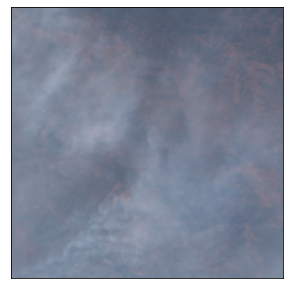

In [31]:
from skimage.transform import rescale

scaled = rescale(blocks[1,1][0, :, :, :] , scale=0.2, preserve_range=True, multichannel=True)
print(scaled.shape, blocks[1,1][0, :, :, :].shape)
plot_image(scaled, factor=5/2e4, clip_range=(0,1), figsize=(5, 5))